# XGBoost

In [9]:
# Bloc non affiché

import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score, matthews_corrcoef, make_scorer


from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import GridSearchCV




def result_model(model,X,Y, f1 = True, f1_aff = True, mat = True) :
    Y_model =model.predict(X)

    if f1:
        f1_scor = f1_score(Y,Y_model)
        if f1_aff:
            print('Le f1 score vaut',f1_scor)
        return(f1_scor)
        
        
    # Matrice de confusion
    if mat:
        cm_model = confusion_matrix(Y, Y_model)
        plt.rcParams['figure.figsize'] = (5, 5)
        sns.heatmap(cm_model, annot = True)
        plt.title(str(model))
        plt.show()
    

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 6


## Téléchargement des données

In [2]:
train = pd.read_csv("https://www.data.mclavier.com/prj_datascience/train_v1.csv")

## Pre-processing

On sépare dans un premier temps les variables explicatives et la variable à expliquer.

In [3]:
X = train.drop(columns='Response')
Y = train['Response']

Ensuite, on décompose en bdd train et test puis on scale les données grâce à sklearn.

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,train_size = 0.85)

Le modèle final sera entrainé sur l'intégralité de la base que nous possédons. Mais actuellement, nous souhaitons mesure le caractère prédictif de nos données et donc pour éviter l'overfitting, nous séparons tout de même nos données.

## Implémentation

In [5]:
xgb0 = xgb.XGBClassifier(use_label_encoder=False)
xgb0.fit(X_train, Y_train)

[10:57:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [6]:
f1_max = result_model(xgb0, X_test, Y_test, mat = False)

Le f1 score vaut 0.38239851255035634


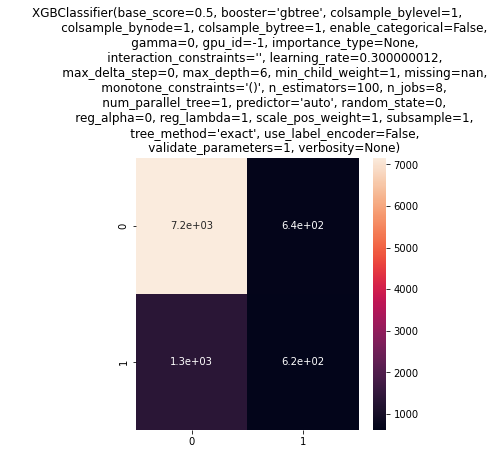

In [11]:
result_model(xgb0, X_test, Y_test, mat = True, f1 = False)

Visualisation du graphique de **feature importance**.

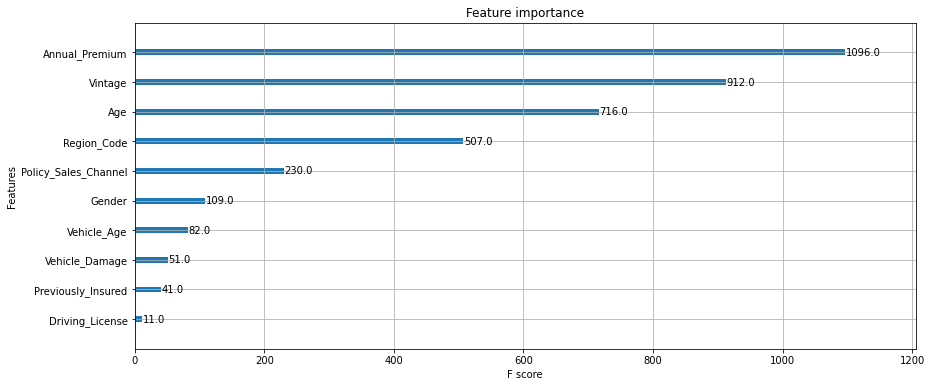

In [10]:
xgb.plot_importance(xgb0)
plt.show()

```{note}
Après le tuning des paramètres, l'importance de certaines variables peuvent changer. Un autre appel à *plot_importance* sera réalisé en fin de notebook.
```

## Tuning

Pour tuner le programme, on s'inspire grandement de [ce site](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#h2_9).
Nous utilisons la fonction GridSearchCV de *sklearn*.

In [45]:
from sklearn.model_selection import GridSearchCV  

Si la metrics f1 existait dans la fonction cv d'XGBoost, nous aurions pu utiliser de la cross validation pour adapter *n_estimators* au fur et à mesure du tuning. Actuellement, ce n'est pas le cas, nous nous contenterons d'utiliser la même méthode d'entrainement et de test que précédemment. Ceci a pour intérêt de permettre de comparer les résultats.

Voici l'algorithme pour l'exemple : 

In [46]:
def modelfit(alg, dtrain, predictors, useTrainCV = True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='error', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
    
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    # dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    print("\nEstimateur efficient :", cvresult.shape[0])
    print("\nMesures :")
    print("---------")
    print("f1 : ", f1_score(dtrain[target].values, dtrain_predictions))

    return(alg)

### Étape 1 : Initialisation

Dans un premier temps, on récupère les paramètres de base que l'on va tuner par la suite.

In [47]:
params = xgb0.get_xgb_params()
params['n_estimators'] = 100
params['verbosity'] = 0

On modifie quelques paramètres de base.

In [48]:
params['seed'] = 27 # Pour retrouver les résultats
params['nthread'] = 7 # Utilisation maximale des capacités de la machine utilisée
params["use_label_encoder"] = False # Masquer les warning.

Le paramètre *n_estimators* est particulier, nous l'estimerons plusieurs fois à différentes étapes du tuning.

Nous définissons dans un premier temps les valeurs que l'on souhaite tester.

Nous utilisons l'outil gsearch de *sklearn* pour tester différents paramètres en ayant comme mesure de scoring le F1-Score. Voici l'implémentation qui sera masquée par la suite.

In [49]:
target = 'Response'
predictors = [x for x in train.columns if x not in [target]]

In [50]:
param_estimator1 = {
 'n_estimators':[50, 80, 100, 900, 1000]
}

In [51]:
gsearch_est1 = GridSearchCV(
    estimator = XGBClassifier(**params),
    param_grid = param_estimator1, scoring='f1', n_jobs=4, cv=5)
 
gsearch_est1.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=8, nthread=7,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, subs

On récupère les paramètres optimaux identifiés.

In [ ]:
gsearch_est1.best_params_, gsearch_est1.best_score_

({'n_estimators': 1000}, 0.40548819026663674)

Nous modifions le paramètres *n_estimators* suite au résultat ci-dessus.

In [54]:
params["n_estimators"] = 1000   

```{note}
Le F1-Score en sortie du grid_search ne peut pas être comparé complètement au f1 initial car le grid_search utilise de la cross validation et donc pas le même jeu de données test.
```

Nous entrainons le modèle avec les nouveaux paramètres pour pouvoir comparer. Par la suite, cette étape ne sera pas tout le temps réalisée.

Le f1-score s'est amélioré de 0.02 point. Nous continuons le tuning.

### Étape 2 : max_depth et min_child_weight

In [ ]:
params["n_estimators"] = 140

On tune max_depth et min_child_weight

In [15]:
param_test1 = {
 'max_depth': range(3,10,2),
 'min_child_weight' : range(1,6)
}

Nous utilisons l'outil gsearch de *sklearn* pour tester différents paramètres en ayant comme mesure de scoring le F1-Score. Voici l'implémentation qui sera masquée par la suite.

In [16]:
gsearch1 = GridSearchCV(
    estimator = XGBClassifier(**params),
    param_grid = param_test1, scoring='f1', n_jobs=4, cv=5)
 
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()', n_estimators=80,
                                     n_jobs=8, nthread=7, num_parallel_tree=1,
                                     predictor='auto', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, subsa

On récupère les paramètres optimaux identifiés.

Nous pouvons modifier *min_child_weight* dans les paramètres.

In [18]:
params["max_depth"] = 9
params["min_child_weight"] = 2

Étant à la limite sur les deux paramètres, nous testons avec des paramètres plus forts.

In [88]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 50, 'min_child_weight': 5}, 0.4190558425538005)

Nous pouvons essayer d'affiner l'ajustement.

In [90]:
param_test2b = {
    'max_depth':[45, 50, 55],
}

In [82]:
gsearch2b = GridSearchCV(
                estimator = XGBClassifier(**params), 
                param_grid = param_test2b, scoring='f1',n_jobs=4, cv=5)

gsearch2b.fit(train[predictors],train[target])

[13:15:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=50,
                                     min_child_weight=5, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=1000, n_jobs=8, nthread=7,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, su

In [83]:
gsearch2b.best_params_, gsearch2b.best_score_

({'max_depth': 50}, 0.4190558425538005)

On conserve donc max_depth = 50.

### Étape 3 : Gamma

Maintenant, nous répétons le même mécanisme pour le paramètre *Gamma*.

1. Définir les valeurs de Gamma à tester
2. Utiliser GridSearchCV
3. Choisir de conserver, modifier, ou d'affiner encore Gamma.

In [57]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

In [58]:
gsearch3 = GridSearchCV(estimator = XGBClassifier(**params), 
                        param_grid = param_test3, scoring='f1',n_jobs=4, cv=5)

gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=50,
                                     min_child_weight=5, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=140, n_jobs=8, nthread=7,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, sub

In [59]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.41722053132398057)

In [120]:
params["gamma"] = 0

Nous ne modifions pas *Gamma* et laissons le paramètre à 0.

Avant de continuer, nous ré-augmentons n_estimators pour voir quel est l’impact sur le modèle si nous augmentons le nombre de boosting rounds.

In [121]:
params["n_estimators"] = 1000
xgb2 = XGBClassifier(**params)
xgb2 = xgb2.fit(X_train, Y_train)

[14:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [104]:
result_model(xgb2, X_test, Y_test, mat = False)

Le f1 score vaut 0.42545160420598543


### Etape 4 : subsample et colsample_bytree

Nous rétablissons *n_estimators* pour la puissance de calcul.

In [122]:
params["n_estimators"] = 140

Génération des paramètres à tester :

In [63]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

In [64]:
gsearch4 = GridSearchCV(
    estimator = XGBClassifier(**params), 
    param_grid = param_test4, scoring='f1',n_jobs=4, cv=5)
    
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=50,
                                     min_child_weight=5, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=140, n_jobs=8, nthread=7,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, sub

In [65]:
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.7}, 0.42095524066535334)

Nous modifions les paramètres identifiés

In [123]:
params["subsample"] = 0.7
params["colsample_bytree"] = 0.9

Nous affinons les tests sur ces paramètres.

In [70]:
param_test5 = {
 'subsample':[i/100.0 for i in range(65,80,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}

In [71]:
gsearch5 = GridSearchCV(
                estimator = XGBClassifier(**params), 
                param_grid = param_test5, scoring='f1',n_jobs=4, cv=5)

gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.9,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=50,
                                     min_child_weight=5, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=140, n_jobs=8, nthread=7,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, s

In [73]:
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.7}, 0.42095524066535334)

Cela confirme les valeurs 0.9 et 0.7 trouvées précédemment.

### Étape 5 : reg_alpha

Prochaine étape : optimisation de *reg_alpha*.

In [124]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

In [78]:
gsearch6 = GridSearchCV(estimator = XGBClassifier(**params), 
                        param_grid = param_test6, scoring='f1',n_jobs=4, cv=5)
                        
gsearch6.fit(train[predictors],train[target])

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9,
                                     enable_categorical=False, gamma=0.1,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=50, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=7,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_wei

In [80]:
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1e-05}, 0.41076480565646045)

On modifie le paramètre.

In [125]:
params["reg_alpha"] = 1e-5

Avant de continuer, nous ré-augmentons n_estimators pour voir quel est l’impact sur le modèle si nous augmentons le nombre de boosting rounds.

In [126]:
params["n_estimators"] = 1000
xgb3 = XGBClassifier(**params)
xgb3 = xgb3.fit(X_train, Y_train)

[14:32:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [127]:
result_model(xgb3, X_test, Y_test, mat = False)

Le f1 score vaut 0.42837874291880224


### Etape 6 : Learning rate

Enfin, nous essayons de diminuer le *learning_rate* et d'augmenter grandement les *n_estimators*.

In [ ]:
params["n_estimators"] = 5000
params["learning_rate"] = 0.01

In [ ]:
xgb4 = XGBClassifier(**params)
xgb4 = xgb4.fit(X_train, Y_train)

[14:35:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
result_model(xgb4, X_test, Y_test, mat = False)

Le f1 score vaut 0.4172222222222222


Le F1-Score ne s'améliore pas, nous revenons aux anciens paramètres.

In [ ]:
params["n_estimators"] = 1000
params["learning_rate"] = 0.1

## Random Under Sampler


Une autre idée pour améliorer notre XGBoost est de travailler sur la forme des données d'entrainement. Actuellement le jeux de données est non équilibré, c'est-à-dire que nous avons plus de Y ayant une valeur de 0 que de 1.

Pour résoudre ce problème nous utilisons une librairie permettant de réaliser du **random under sampler** et réajustant à souhait la répartition des 1 et des 0 dans notre base de données d'entrainement.

In [63]:
from imblearn.under_sampling import RandomUnderSampler

Dans un premier temps nous définissons la fonction *model_rus(alpha, model, X_train, Y_train)* et *f1_scorer(model, X, Y)*.

In [64]:
def model_rus(alpha,model, X_train, Y_train) :
    rus = RandomUnderSampler(sampling_strategy = alpha)
    X_rus , Y_rus = rus.fit_resample(X_train ,Y_train)
    model.fit(X_rus,Y_rus)
    return model

def f1_scorer(model,X,Y) :
    Y_model = model.predict(X)
    score = f1_score(Y,Y_model)
    return score

Grâce à ses fonctions, nous évaluons notre modèle XGBoost avec des jeux de données plus ou moins équilibrés. 

$$
\alpha = \frac{\text{Nombre de 1}}{\text{Nombre de 0}}
$$

Lorsque $\alpha = 1$ les données sont parfaitement balancées (50% /50%).

In [65]:
list_model = []
list_alpha =  np.linspace(0.8,1,10)
score_alpha = []

xgb_rus = XGBClassifier(**params)

for alpha in list_alpha :
    temp_m = model_rus(alpha,xgb_rus, X_train, Y_train)
    list_model.append(temp_m)
    f1 = f1_scorer(temp_m,X_test , Y_test)
    score_alpha.append(f1)

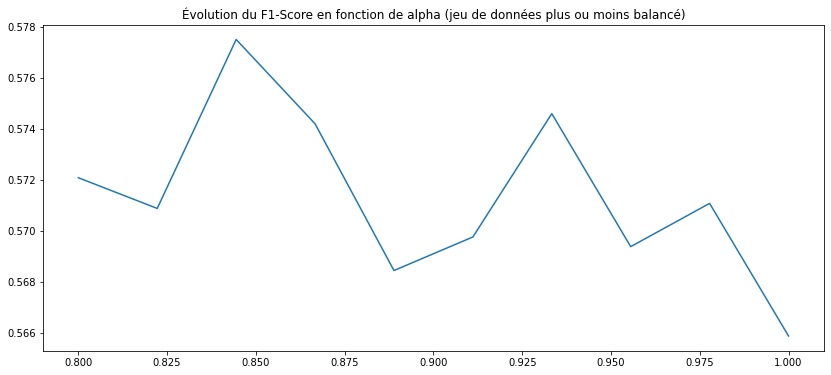

In [75]:
plt.plot(list_alpha, score_alpha)
plt.title("Évolution du F1-Score en fonction de alpha (jeu de données plus ou moins balancé)")

plt.show()

In [67]:
# Index qui optimise le f1 score
max_value = max(score_alpha)
max_index = score_alpha.index(max_value)
print("On choisit donc alpha = ", np.round(list_alpha[max_index], 3))

On choisit donc alpha =  0.844


Le F1-Score s'améliore grandement lorsque l'entrainement se fait sur des données équilibrées. Nous nous rapprochons des valeurs du random forest.

In [68]:
# Modèle final
xgb5 = XGBClassifier(**params)
rus = RandomUnderSampler(sampling_strategy = list_alpha[max_index])
X_rus , Y_rus = rus.fit_resample(X_train ,Y_train)
xgb5 = xgb5.fit(X_rus, Y_rus)

In [70]:
f1 = result_model(xgb5, X_test, Y_test, mat = False)

Le f1 score vaut 0.5726674160912157


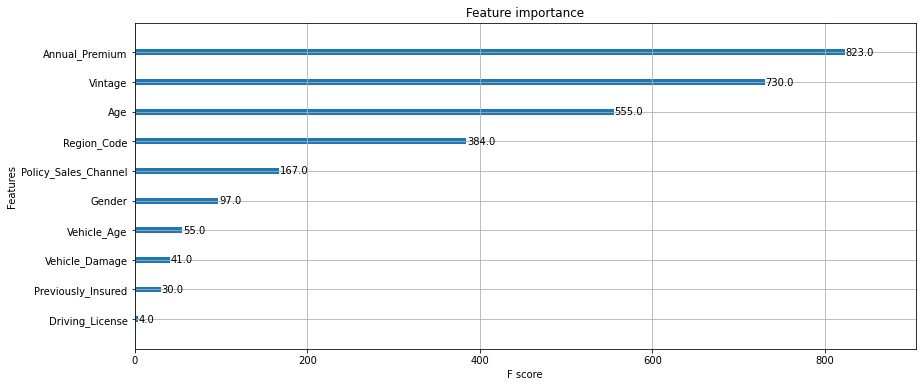

In [73]:
xgb.plot_importance(xgb5)
plt.show()

## Tuning après RUS

Suite au gain important grâce au RUS, nous recommençons le tuning avec une méthode permettant d'utiliser la bdd X_rus (sans cross validation pour conserver plus de données).

In [120]:
def my_gsearch(params, param_grid, name_param, X_train, Y_train):

    best_param = params[name_param]
    xgb1 = XGBClassifier(**params)
    xgb1.fit(X_train, Y_train)
    f1_max = result_model(xgb1, X_test, Y_test, mat = False, f1_aff = False)

    for n_est in param_grid[name_param]:
        params[name_param] = n_est
        xgb1 = XGBClassifier(**params)
        xgb1.fit(X_train, Y_train)
        f1_temp = result_model(xgb1, X_test, Y_test, mat = False, f1_aff = False)

        if f1_temp > f1_max:
            best_param = n_est
            f1_max = f1_temp

    params[name_param] = best_param
    print('Variable :', name_param, '(f1 :', f1_max, ', param :', best_param, ')')
    return(params, f1_max)

Nous reprenons les paramètres du xgb0.

In [121]:
params = xgb0.get_xgb_params()
params['n_estimators'] = 100
params['verbosity'] = 0

params['seed'] = 27 # Pour retrouver les résultats
params['nthread'] = 7 # Utilisation maximale des capacités de la machine utilisée
params["use_label_encoder"] = False # Masquer les warning.

In [122]:
rus = RandomUnderSampler(sampling_strategy = 0.844)
X_rus , Y_rus = rus.fit_resample(X_train ,Y_train)

In [123]:
param_test = {
  'n_estimators':[10, 15, 20, 21, 22, 23, 25, 27, 100, 1000],
  'max_depth':[1,3,4, 5,6,7], 
  'min_child_weight':[1, 2, 3, 4, 5],
  'gamma':[i/10.0 for i in range(0,5)], 
  'subsample':[i/10.0 for i in range(6,10)],
  'colsample_bytree':[i/10.0 for i in range(6,10)], 
  'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

params, f1_max = my_gsearch(params, param_test, 'n_estimators', X_rus, Y_rus)
params, f1_max = my_gsearch(params, param_test, 'max_depth', X_rus, Y_rus)
params, f1_max = my_gsearch(params, param_test, 'min_child_weight', X_rus, Y_rus)
params, f1_max = my_gsearch(params, param_test, 'gamma', X_rus, Y_rus)
params, f1_max = my_gsearch(params, param_test, 'subsample', X_rus, Y_rus)
params, f1_max = my_gsearch(params, param_test, 'colsample_bytree', X_rus, Y_rus)
params, f1_max = my_gsearch(params, param_test, 'colsample_bytree', X_rus, Y_rus)
params, f1_max = my_gsearch(params, param_test, 'reg_alpha', X_rus, Y_rus)

Variable : n_estimators (f1 : 0.5822110867522706 , param : 23 )
Variable : max_depth (f1 : 0.5836936380481779 , param : 3 )
Variable : min_child_weight (f1 : 0.5841828853877047 , param : 4 )
Variable : gamma (f1 : 0.5841828853877047 , param : 0 )
Variable : subsample (f1 : 0.5845674201091192 , param : 0.6 )
Variable : colsample_bytree (f1 : 0.5845674201091192 , param : 1 )
Variable : colsample_bytree (f1 : 0.5845674201091192 , param : 1 )
Variable : reg_alpha (f1 : 0.5845674201091192 , param : 0 )


In [125]:
xgb_rus = xgb.XGBClassifier(**params)
xgb_rus.fit(X_rus, Y_rus)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=23, n_jobs=8, nthread=7,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=0.6, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [126]:
f1 = result_model(xgb_rus, X_test, Y_test)

Le f1 score vaut 0.5845674201091192


## BDD brute

Enfin, nous testons les paramètres trouvés (en conservant le RUS) avec la base de données où la variable *Policy_Sales_Channel* n'a pas été retraitée.

In [128]:
# Importation des données

train_v3 = pd.read_csv("https://www.data.mclavier.com/prj_datascience/train_v3.csv")

X = train_v3.drop(columns='Response')
Y = train_v3['Response']

X_train_v3, X_test_v3, Y_train_v3, Y_test_v3 = train_test_split(X, Y,train_size = 0.85)

rus = RandomUnderSampler(sampling_strategy = 0.844)
X_rus2 , Y_rus2 = rus.fit_resample(X_train_v3 ,Y_train_v3)

Ensuite, on décompose en bdd train et test puis on scale les données grâce à sklearn.

In [129]:
xgbf = xgb.XGBClassifier(**params)
xgbf.fit(X_rus2, Y_rus2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=23, n_jobs=8, nthread=7,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=0.6, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [131]:
f1 = result_model(xgbf, X_test, Y_test)

Le f1 score vaut 0.5724148281554854


Nous n'améliorons pas le f1-score en utilisant la base de données non traitée. Nous gardons donc comme base d'entrainement la train_v1.csv.

## Paramètres finaux

Finalement, l'optimisation se fait à travers les paramètres et la base de données d'entrainement. La base de données d'entrainement doit être équilibrée avec un coefficient $\alpha = 0.833$ et les paramètres sont :

In [132]:
params

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 4,
 'monotone_constraints': '()',
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.6,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0,
 'n_estimators': 23,
 'seed': 27,
 'nthread': 7,
 'use_label_encoder': False}

Nous reprendons ces paramètres dans le prochain notebook concernant le modèle final utilisé pour générer les prédictions sur la base test.

## Conclusion

Tuner un modèle XGBoost nécessite énormement de temps de calcul. Dans ce projet, nous avons restreint le nombre de paramètres. Bien sûr, avec davantage de puissance, nous aurions pu calibrer plus précisement les paramètres étudiés et tuner d'autres paramètres.

<br><br><br><br><br>

## Rappels théoriques

Le Boosting de Gradient est un algorithme d’apprentissage supervisé dont le principe est de combiner les résultats d’un ensemble de modèles moins performants afin de fournir la meilleure prédiction possible.

Un exemple classique est le modèle linéaire défini comme ci-suit  $\hat{y}_i = \sum_j \theta_j x_{ij}$ qui représente une combinaison de plusieurs variables plus ou moins significatives.

En choisissant judicieusement notre $y_i$, nous pouvons à partir de notre jeu de données faire des régressions et de la classification.

Lorque nous entrainons notre modèle, nous cherchons à définir le meilleur paramètre $ \theta  $ qui ajustera nos données $x_i$ et nous permettra d'obtenir les meilleurs prédictions de $y_i$. Pour entrainer notre modèle, nous avons besoin d'une fonction dite d'objectif afin d'estimer si notre modèle est performant ou non. \
Notre fonction dite d'objectif est définie de la manière suivante :
$$\text{obj}(\theta) = L(\theta) + \Omega(\theta)$$

Dans cette expression nous retrouvons deux composants :\
Le premier $L$, la fonction d'entrainement, le second $\Omega$ qui est le terme de régulation.\
$L$ va donc estimer la performance prédicitive de notre modèle.\
Un choix classique pour $L$ est la mesure la mean squared error (MSE) donnée par : $$ L(\theta) = \sum_i (y_i-\hat{y}_i)^2  $$

Il existe également la fonction de logistic loss qui peut également être utilisée comme fonction d'entrainement: 

$$ L(\theta) = \sum_i[ y_i\ln (1+e^{-\hat{y}_i}) + (1-y_i)\ln (1+e^{\hat{y}_i})]  $$

Le terme de régulation est assez souvent oublié; c'est pourtant lui qui contrôle la complexité du modèle et nous empêche d'entrainer notre modèle en overfittant.

![Texte alternatif](https://drive.google.com/uc?id=1ks-oizjnu3-rThY-gecix6BpKFWy__FM)

La présentation de la méthode XGBoost ne peut se faire sans introduire la notion d'arbre de décision.

![Texte alternatif](https://drive.google.com/uc?id=1R7HcQg2z2cJ14GSCOL45VsWfHGT0-f37)

Dans notre exemple, il s'agit d'un modèle qui doit classifier suivant deux variables l'âge ainsi que l'utilisation quotidienne d'un ordinateur. Le modèle alloue a chaque échantillon un score de prédiction.

Mathématiquement, le score peut s'écrire sous la forme :

$$\hat{y}_i = \sum_{k=1}^K f_k(x_i), f_k \in \mathcal{F}$$

où $K$ est le nombre d'arbres, $f$ une fonction dans $\mathcal{F}$ et $\mathcal{F}$ est l'ensemble des arbres de classification et de regression.\
L'objectif est d'optimiser la fonction suivante : 

$$ \text{obj}(\theta) = \sum_i^n l(y_i, \hat{y}_i) + \sum_{k=1}^K \Omega(f_k)$$

Mainteant que nous avons introduit le modèle, nous pouvons passer à l'entrainement de ce dernier. Nous allons définir une fonction d'objectif que nous optimiserons.\
Notre fonction d'objectif est définie comme étant :

$$ \text{obj} = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\Omega(f_i) $$

Nous devons chercher premièrement les paramètres de notre arbre. Les structures de nos arbres sont contenues dans les fonctions $f_i$. Il s'avère complexe d'optimiser la structure d'un arbre, il ne s'agit pas simplement de problèmes de gradients.\
Ici nous fixons ce que nous avons à apprendre puis nous ajoutons un arbre à la fois. Notre valeur de prédiction avec un pas de $t$ pour la fonction $\hat{y}_i^{(t)}$ s'écrit : 


$$

\begin{split}

\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)

\end{split}

$$

La question qui se pose alors est : quel arbre ajouter après un pas ?. La réponse est l'arbre qui optimise le mieux notre prédiction.


$$

\begin{split}

\text{obj}^{(t)} & = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) + \Omega(f_t) + \mathrm{constant}

\end{split}

$$

Lorsque la mean squared error (MSE) est utilisée, notre fonction d'objectif devient 

$$

\begin{split}

\text{obj}^{(t)} & = \sum_{i=1}^n (y_i - (\hat{y}_i^{(t-1)} + f_t(x_i)))^2 + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n [2(\hat{y}_i^{(t-1)} - y_i)f_t(x_i) + f_t(x_i)^2] + \Omega(f_t) + \mathrm{constant}

\end{split}

$$

L'utilisation de la MSE est assez courante avec un résidu et un terme quadratique.
La fonction d'objectif devient alors : 

$$ \text{obj}^{(t)} = \sum_{i=1}^n [l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t) + \mathrm{constant} $$
 
 où $g_i$ et $h_i$ sont :

$$

 \begin{split}

 g_i &= \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)})\\
h_i &= \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)})

\end{split}

$$
Après suppression de toutes les constantes, nous obtenons : 

$$\sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t)$$

Cette expression devient notre objectif pour les nouveaux arbres. La valeur de notre prédiction ne va alors dépendre que de $g_i$ et $h_i$. Il est possible d'optimiser chaque loss function en utilisant simplement les mêmes entrées $g_i$et $h_i$.

Maintenant que le terme d'entrainement est déterminé, il est nécessaire de définir le terme de régulation qui intervient dans la gestion de la complexité du modèle.\
La complexité de notre arbre est représentée par $\Omega(f)$ qui est defini par la fonction $f(x)$ :

$$f_t(x) = w_{q(x)}, w \in R^T, q:R^d\rightarrow \{1,2,\cdots,T\} .$$

où $w$ est le  vecteur de score, $q$ est la fonction qui alloue la bonne feuille et $T$ le nombre de feuilles.
Pour la méthode XGBoost, nous pouvons définir la complexité du modèle comme étant :

$$ \Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2 $$

Il existe d'autres façons de définir la complexité du modèle; cependant celle énoncée précédemment s'avère être fonctionnelle et efficace. L'aspect de régulation est souvent sous-estimé voir même ignoré. En définissant la complexité de façon formelle, nous avons un meilleur aperçu de notre modèle et de son niveau de performance.

Structure du score :

Maintenant que nous avons défini notre modèle, notre valeur objectif peut s'écrire de la façon suivante :

$$

\begin{split}

\text{obj}^{(t)} &\approx \sum_{i=1}^n [g_i w_{q(x_i)} + \frac{1}{2} h_i w_{q(x_i)}^2] + \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2\\
&= \sum^T_{j=1} [(\sum_{i\in I_j} g_i) w_j + \frac{1}{2} (\sum_{i\in I_j} h_i + \lambda) w_j^2 ] + \gamma T

\end{split}

$$

où $I_j = \{i|q(x_i)=j\}$représentent les indices des nos points dans notre arbre.\
L'expression de notre valeur objectif peut être simplifiée.
Nous définissons $G_j = \sum_{i\in I_j} g_i$ et $H_j = \sum_{i\in I_j} h_i$; l'expression de notre valeur objectif devient alors :

$$\text{obj}^{(t)} = \sum^T_{j=1} [G_jw_j + \frac{1}{2} (H_j+\lambda) w_j^2] +\gamma T$$

où les $w_j$ sont indépendants, $G_jw_j+\frac{1}{2}(H_j+\lambda)w_j^2$ est une expression de la forme quadratique. Pour le meilleur $w_j$ possible, nous pouvons écrire : 

$$

\begin{split}

w_j^\ast &= -\frac{G_j}{H_j+\lambda}\\
\text{obj}^\ast &= -\frac{1}{2} \sum_{j=1}^T \frac{G_j^2}{H_j+\lambda} + \gamma T

\end{split}

$$

C'est la dernière expression qui va déterminer la qualité de notre modèle en évaluant la qualité de la prédiction.

Après avoir mesuré la qualité de notre modèle, nous allons énumérer le nombre d'arbres possibles afin de choisir le meilleur. C'est probablement impossible à réaliser avec l'infinité de combinaisons possibles. Il faut donc chercher à optimiser l'arbre niveau par niveau. Nous calculons de ce fait le gain entre un arbre et l'autre à l'aide de la formule suivante : 

$$ Gain = \frac{1}{2} \left[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right] - \gamma $$

Ici, nous comparons le gain entre deux nouveaux arbres et celui que nous utilisons actuellement. Si le gain est inferieur au $\gamma$ il est plus préférable de ne pas ajouter le nouvel arbre.  

<br><br><br><br>